In [1]:
# config
import sys
import numpy as np
import torch
assert torch.cuda.is_available()
%matplotlib inline
cuda_device = torch.device("cuda:0")
torch.cuda.set_device(cuda_device)
from config import config
setting = config(
    cuda_device, 
    model_save_name="", 
    dataset_name="SHA",
    lr=1e-4, 
    batch_size=5, 
    eval_per_step=120
)

In [2]:
from Dataset.DatasetConstructor import TrainDatasetConstructor,EvalDatasetConstructor
eval_dataset = EvalDatasetConstructor(
    setting.eval_num,
    setting.eval_img_path,
    setting.eval_gt_map_path,
    setting.eval_pers_path,
    mode=setting.mode,
    dataset_name=setting.dataset_name,
    device=setting.cuda_device)
eval_loader = torch.utils.data.DataLoader(dataset=eval_dataset, batch_size=1)

In [3]:
# model construct
from net.RES_PERS_FPN.PERS_FPN import PERS_FPN
from eval.Estimator import Estimator
net = PERS_FPN(sigma=[1, 1, 0, 1], updates_signal=[True, True, True, True]).to(setting.cuda_device)
net.load_state_dict(torch.load("/home/zzn/PycharmProjects/RESNET_FPN/StateDicts/RES_50_PERS_FPN_A_7_7.pkl"))
optimizer = torch.optim.Adam(net.parameters(), setting.learning_rate)
criterion = torch.nn.MSELoss(reduction='sum').to(setting.cuda_device)
estimator = Estimator(setting, eval_loader, criterion=criterion)

In [18]:
print(list(list(list(list(net.children())[1].children())[1].children())[0].children())[0].params)
print(list(list(list(list(net.children())[1].children())[3].children())[0].children())[0].params)
print(list(list(list(list(net.children())[1].children())[5].children())[0].children())[0].params)
print(list(list(list(list(net.children())[1].children())[6].children())[0].children())[0].params)

Parameter containing:
tensor([0.7402, 0.8050, 0.1231, 1.1611], device='cuda:0', requires_grad=True)
Parameter containing:
tensor([1.0885, 1.0243, 0.0258, 0.9929], device='cuda:0', requires_grad=True)
Parameter containing:
tensor([1.2207, 0.9564, 0.0819, 0.9782], device='cuda:0', requires_grad=True)
Parameter containing:
tensor([ 0.8524,  0.8621, -0.1094,  0.8828], device='cuda:0',
       requires_grad=True)


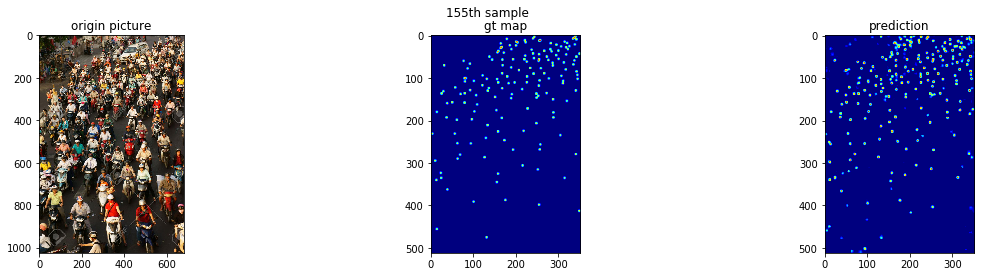

The gt counts of the above sample:165, and the pred counts:199.37158203125
loss = 7.331442050226442, eval_mae = 62.81157684326172, eval_rmse = 113.56316375732422, time cost eval = 29.03201413154602s


In [7]:
import warnings
import time
validate_MAE, validate_RMSE, validate_loss, time_cost = estimator.evaluate(net, True)
sys.stdout.write('loss = {}, eval_mae = {}, eval_rmse = {}, time cost eval = {}s\n'
                .format(validate_loss, validate_MAE, validate_RMSE, time_cost))
sys.stdout.flush()